# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

import os
import random
import shutil

def split_images(image_dir, train_dir, valid_dir, validation_percentage=20):
    # Create train and validation directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    # Collect all .tiff files from all subdirectories
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.tiff', 'tiff')):
                image_files.append(os.path.join(root, file))

    # Shuffle the files randomly
    random.shuffle(image_files)

    # Split the images into training and validation sets
    total_images = len(image_files)
    validation_count = int(total_images * validation_percentage / 100)

    validation_files = image_files[:validation_count]
    training_files = image_files[validation_count:]

    # Move files to train and validation directories
    for file_path in training_files:
        destination = os.path.join(train_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    for file_path in validation_files:
        destination = os.path.join(valid_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    print(f"Total images: {total_images}")
    print(f"Training images: {len(training_files)}")
    print(f"Validation images: {len(validation_files)}")

# Example usage
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
train_dir = r"../../tiff_experiment_unsupervised_data/train"
valid_dir = r"../../tiff_experiment_unsupervised_data/validation"

split_images(image_dir, train_dir, valid_dir, validation_percentage=20)


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import functional as Func

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'

In [5]:
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()
# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_1776\2711482870.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [7]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [9]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['control', 'treated']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [10]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1])


In [11]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 201


In [12]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 51


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [14]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  8%|▊         | 1/13 [00:01<00:12,  1.03s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 15%|█▌        | 2/13 [00:01<00:09,  1.16it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 23%|██▎       | 3/13 [00:02<00:07,  1.26it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 31%|███       | 4/13 [00:03<00:06,  1.29it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 5/13 [00:03<00:06,  1.33it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 46%|████▌     | 6/13 [00:04<00:05,  1.34it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 54%|█████▍    | 7/13 [00:05<00:04,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▏   | 8/13 [00:06<00:03,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 69%|██████▉   | 9/13 [00:06<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 77%|███████▋  | 10/13 [00:07<00:02,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 85%|████████▍ | 11/13 [00:08<00:01,  1.32it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 92%|█████████▏| 12/13 [00:09<00:00,  1.34it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Batch features shape: torch.Size([9, 512])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([201, 512])
Labels shape after concatenation: torch.Size([201])


 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

Batch features shape: torch.Size([3, 512])
Batch labels shape: torch.Size([3])
Features shape after concatenation: torch.Size([51, 512])
Labels shape after concatenation: torch.Size([51])


In [15]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [16]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [18]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 272.78it/s]


Training loss: 0.2254, Training accuracy: 0.9353
Test loss: 0.0574, Test accuracy: 1.0000
Epoch 2/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 321.17it/s]


Training loss: 0.0399, Training accuracy: 1.0000
Test loss: 0.0461, Test accuracy: 1.0000
Epoch 3/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 198.78it/s]


Training loss: 0.0388, Training accuracy: 1.0000
Test loss: 0.0458, Test accuracy: 1.0000
Epoch 4/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 315.13it/s]


Training loss: 0.0389, Training accuracy: 1.0000
Test loss: 0.0454, Test accuracy: 1.0000
Epoch 5/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 196.71it/s]


Training loss: 0.0379, Training accuracy: 1.0000
Test loss: 0.0449, Test accuracy: 1.0000
Epoch 6/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 186.09it/s]


Training loss: 0.0385, Training accuracy: 1.0000
Test loss: 0.0445, Test accuracy: 1.0000
Epoch 7/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 275.19it/s]


Training loss: 0.0371, Training accuracy: 1.0000
Test loss: 0.0440, Test accuracy: 1.0000
Epoch 8/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 242.56it/s]


Training loss: 0.0368, Training accuracy: 1.0000
Test loss: 0.0435, Test accuracy: 1.0000
Epoch 9/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 370.98it/s]


Training loss: 0.0363, Training accuracy: 1.0000
Test loss: 0.0430, Test accuracy: 1.0000
Epoch 10/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 212.88it/s]


Training loss: 0.0368, Training accuracy: 1.0000
Test loss: 0.0425, Test accuracy: 1.0000
Epoch 11/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 310.52it/s]


Training loss: 0.0462, Training accuracy: 1.0000
Test loss: 0.0420, Test accuracy: 1.0000
Epoch 12/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 337.83it/s]


Training loss: 0.0353, Training accuracy: 1.0000
Test loss: 0.0415, Test accuracy: 1.0000
Epoch 13/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 246.42it/s]


Training loss: 0.0354, Training accuracy: 1.0000
Test loss: 0.0410, Test accuracy: 1.0000
Epoch 14/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 197.94it/s]


Training loss: 0.0343, Training accuracy: 1.0000
Test loss: 0.0404, Test accuracy: 1.0000
Epoch 15/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 211.26it/s]


Training loss: 0.0345, Training accuracy: 1.0000
Test loss: 0.0399, Test accuracy: 1.0000
Epoch 16/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 244.83it/s]


Training loss: 0.0340, Training accuracy: 1.0000
Test loss: 0.0394, Test accuracy: 1.0000
Epoch 17/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 148.14it/s]


Training loss: 0.0338, Training accuracy: 1.0000
Test loss: 0.0389, Test accuracy: 1.0000
Epoch 18/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 184.78it/s]


Training loss: 0.0328, Training accuracy: 1.0000
Test loss: 0.0383, Test accuracy: 1.0000
Epoch 19/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 212.25it/s]


Training loss: 0.0331, Training accuracy: 1.0000
Test loss: 0.0378, Test accuracy: 1.0000
Epoch 20/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 196.99it/s]


Training loss: 0.0323, Training accuracy: 1.0000
Test loss: 0.0373, Test accuracy: 1.0000
Epoch 21/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 246.25it/s]


Training loss: 0.0338, Training accuracy: 1.0000
Test loss: 0.0368, Test accuracy: 1.0000
Epoch 22/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 169.26it/s]


Training loss: 0.0315, Training accuracy: 1.0000
Test loss: 0.0363, Test accuracy: 1.0000
Epoch 23/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 339.03it/s]


Training loss: 0.0308, Training accuracy: 1.0000
Test loss: 0.0358, Test accuracy: 1.0000
Epoch 24/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 209.49it/s]


Training loss: 0.0305, Training accuracy: 1.0000
Test loss: 0.0353, Test accuracy: 1.0000
Epoch 25/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 529.64it/s]


Training loss: 0.0301, Training accuracy: 1.0000
Test loss: 0.0348, Test accuracy: 1.0000
Epoch 26/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 251.90it/s]


Training loss: 0.0304, Training accuracy: 1.0000
Test loss: 0.0344, Test accuracy: 1.0000
Epoch 27/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 496.88it/s]


Training loss: 0.0296, Training accuracy: 1.0000
Test loss: 0.0339, Test accuracy: 1.0000
Epoch 28/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 246.14it/s]


Training loss: 0.0289, Training accuracy: 1.0000
Test loss: 0.0334, Test accuracy: 1.0000
Epoch 29/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 362.63it/s]


Training loss: 0.0290, Training accuracy: 1.0000
Test loss: 0.0329, Test accuracy: 1.0000
Epoch 30/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 209.41it/s]


Training loss: 0.0282, Training accuracy: 1.0000
Test loss: 0.0325, Test accuracy: 1.0000
Epoch 31/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 231.79it/s]


Training loss: 0.0277, Training accuracy: 1.0000
Test loss: 0.0320, Test accuracy: 1.0000
Epoch 32/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 216.46it/s]


Training loss: 0.0272, Training accuracy: 1.0000
Test loss: 0.0316, Test accuracy: 1.0000
Epoch 33/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 418.69it/s]


Training loss: 0.0270, Training accuracy: 1.0000
Test loss: 0.0312, Test accuracy: 1.0000
Epoch 34/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 224.42it/s]


Training loss: 0.0316, Training accuracy: 1.0000
Test loss: 0.0307, Test accuracy: 1.0000
Epoch 35/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 422.44it/s]


Training loss: 0.0265, Training accuracy: 1.0000
Test loss: 0.0302, Test accuracy: 1.0000
Epoch 36/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 227.04it/s]


Training loss: 0.0262, Training accuracy: 1.0000
Test loss: 0.0298, Test accuracy: 1.0000
Epoch 37/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 445.07it/s]


Training loss: 0.0254, Training accuracy: 1.0000
Test loss: 0.0294, Test accuracy: 1.0000
Epoch 38/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 263.47it/s]


Training loss: 0.0251, Training accuracy: 1.0000
Test loss: 0.0290, Test accuracy: 1.0000
Epoch 39/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 248.49it/s]


Training loss: 0.0252, Training accuracy: 1.0000
Test loss: 0.0287, Test accuracy: 1.0000
Epoch 40/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 212.66it/s]


Training loss: 0.0253, Training accuracy: 1.0000
Test loss: 0.0283, Test accuracy: 1.0000
Epoch 41/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 322.75it/s]


Training loss: 0.0253, Training accuracy: 1.0000
Test loss: 0.0279, Test accuracy: 1.0000
Epoch 42/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 371.92it/s]


Training loss: 0.0242, Training accuracy: 1.0000
Test loss: 0.0275, Test accuracy: 1.0000
Epoch 43/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 214.26it/s]


Training loss: 0.0235, Training accuracy: 1.0000
Test loss: 0.0271, Test accuracy: 1.0000
Epoch 44/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 233.49it/s]


Training loss: 0.0272, Training accuracy: 1.0000
Test loss: 0.0268, Test accuracy: 1.0000
Epoch 45/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 499.12it/s]


Training loss: 0.0294, Training accuracy: 1.0000
Test loss: 0.0264, Test accuracy: 1.0000
Epoch 46/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 289.66it/s]


Training loss: 0.0231, Training accuracy: 1.0000
Test loss: 0.0260, Test accuracy: 1.0000
Epoch 47/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 440.83it/s]


Training loss: 0.0231, Training accuracy: 1.0000
Test loss: 0.0257, Test accuracy: 1.0000
Epoch 48/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 549.52it/s]


Training loss: 0.0238, Training accuracy: 1.0000
Test loss: 0.0253, Test accuracy: 1.0000
Epoch 49/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 584.85it/s]


Training loss: 0.0219, Training accuracy: 1.0000
Test loss: 0.0250, Test accuracy: 1.0000
Epoch 50/50


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 10467.07it/s]


Training loss: 0.0305, Training accuracy: 1.0000
Test loss: 0.0247, Test accuracy: 1.0000


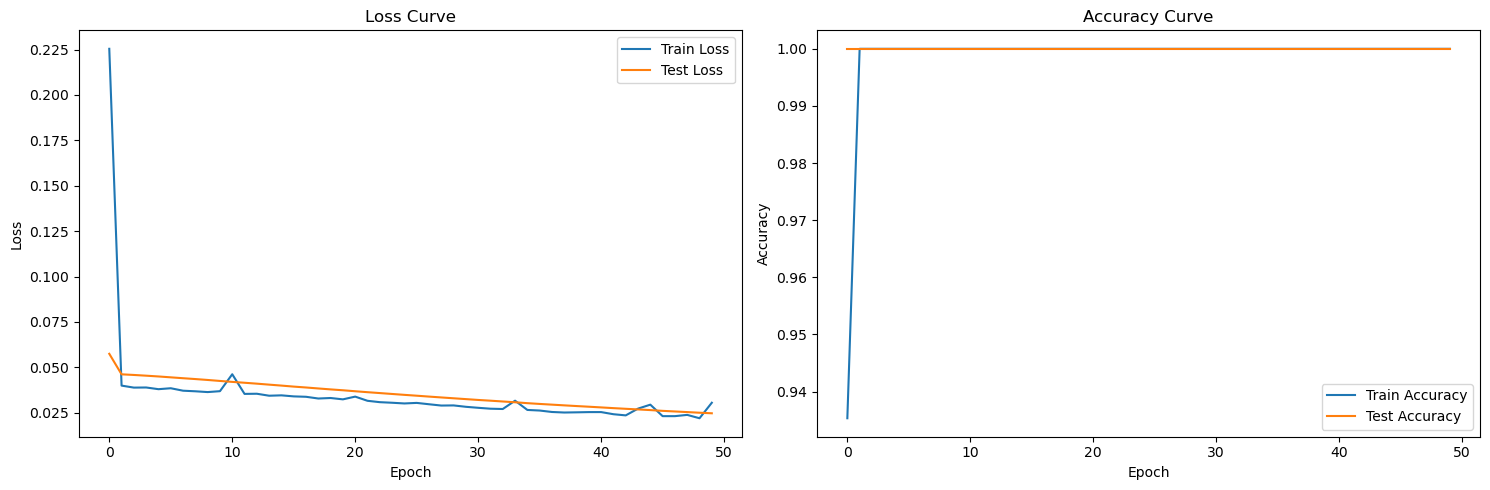

In [19]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=50
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


# after projection head

In [20]:
@torch.no_grad()
def feature_after_projection(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [21]:
# Extract features for train and test datasets
train_feats_after = feature_after_projection(simclr_model, train_loader_labeled)
test_feats_after = feature_after_projection(simclr_model, test_loader_labeled)

  8%|▊         | 1/13 [00:00<00:09,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 15%|█▌        | 2/13 [00:01<00:08,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 23%|██▎       | 3/13 [00:02<00:07,  1.34it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 31%|███       | 4/13 [00:02<00:06,  1.36it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 38%|███▊      | 5/13 [00:03<00:05,  1.36it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 46%|████▌     | 6/13 [00:04<00:05,  1.30it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 54%|█████▍    | 7/13 [00:05<00:04,  1.29it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 62%|██████▏   | 8/13 [00:06<00:03,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 69%|██████▉   | 9/13 [00:06<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 77%|███████▋  | 10/13 [00:07<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 85%|████████▍ | 11/13 [00:08<00:01,  1.35it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 92%|█████████▏| 12/13 [00:09<00:00,  1.34it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


Batch features shape: torch.Size([9, 20])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([201, 20])
Labels shape after concatenation: torch.Size([201])


 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.36it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.37it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch features shape: torch.Size([3, 20])
Batch labels shape: torch.Size([3])


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

Features shape after concatenation: torch.Size([51, 20])
Labels shape after concatenation: torch.Size([51])


Epoch 1/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 212.62it/s]


Training loss: 0.7686, Training accuracy: 0.6070
Test loss: 0.6136, Test accuracy: 0.6471
Epoch 2/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 176.85it/s]


Training loss: 0.7716, Training accuracy: 0.6119
Test loss: 0.6132, Test accuracy: 0.6471
Epoch 3/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 226.76it/s]


Training loss: 0.7730, Training accuracy: 0.6119
Test loss: 0.6129, Test accuracy: 0.6471
Epoch 4/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 383.02it/s]


Training loss: 0.7477, Training accuracy: 0.6119
Test loss: 0.6125, Test accuracy: 0.6471
Epoch 5/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 225.26it/s]


Training loss: 0.7470, Training accuracy: 0.6119
Test loss: 0.6122, Test accuracy: 0.6471
Epoch 6/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 457.64it/s]


Training loss: 0.7584, Training accuracy: 0.6119
Test loss: 0.6118, Test accuracy: 0.6471
Epoch 7/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 216.34it/s]


Training loss: 0.7669, Training accuracy: 0.6119
Test loss: 0.6115, Test accuracy: 0.6667
Epoch 8/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 210.35it/s]


Training loss: 0.7485, Training accuracy: 0.6119
Test loss: 0.6111, Test accuracy: 0.6667
Epoch 9/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 216.59it/s]


Training loss: 0.7450, Training accuracy: 0.6119
Test loss: 0.6108, Test accuracy: 0.6667
Epoch 10/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 317.31it/s]


Training loss: 0.7440, Training accuracy: 0.6119
Test loss: 0.6104, Test accuracy: 0.6667
Epoch 11/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 386.97it/s]


Training loss: 0.7896, Training accuracy: 0.6119
Test loss: 0.6101, Test accuracy: 0.6667
Epoch 12/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 208.40it/s]


Training loss: 0.7605, Training accuracy: 0.6119
Test loss: 0.6097, Test accuracy: 0.6667
Epoch 13/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 306.26it/s]


Training loss: 0.7492, Training accuracy: 0.6119
Test loss: 0.6094, Test accuracy: 0.6667
Epoch 14/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 498.56it/s]


Training loss: 0.8016, Training accuracy: 0.6119
Test loss: 0.6090, Test accuracy: 0.6667
Epoch 15/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 262.25it/s]


Training loss: 0.7829, Training accuracy: 0.6119
Test loss: 0.6087, Test accuracy: 0.6667
Epoch 16/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 213.37it/s]


Training loss: 0.7580, Training accuracy: 0.6119
Test loss: 0.6083, Test accuracy: 0.6667
Epoch 17/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 338.42it/s]


Training loss: 0.7524, Training accuracy: 0.6119
Test loss: 0.6079, Test accuracy: 0.6667
Epoch 18/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 442.34it/s]


Training loss: 0.7376, Training accuracy: 0.6119
Test loss: 0.6076, Test accuracy: 0.6667
Epoch 19/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 221.86it/s]


Training loss: 0.7611, Training accuracy: 0.6119
Test loss: 0.6073, Test accuracy: 0.6667
Epoch 20/20


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 189.99it/s]


Training loss: 0.7923, Training accuracy: 0.6119
Test loss: 0.6069, Test accuracy: 0.6667


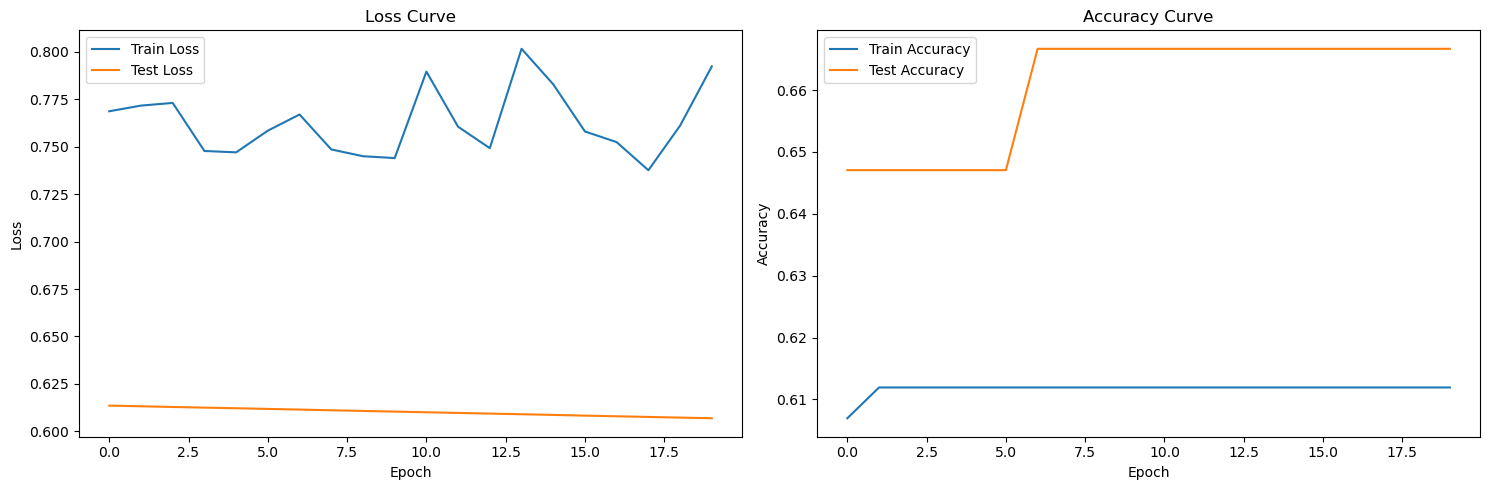

In [22]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_after,
    test_feats_data=test_feats_after,
    feature_dim=train_feats_after.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=20
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [30]:
train_feats_after.tensors[0].shape[1]

20

In [15]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [16]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [18]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [19]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


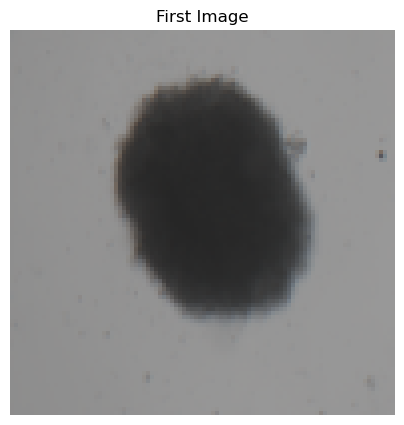

In [20]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [21]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


In [22]:
second_image.shape

torch.Size([3, 96, 96])

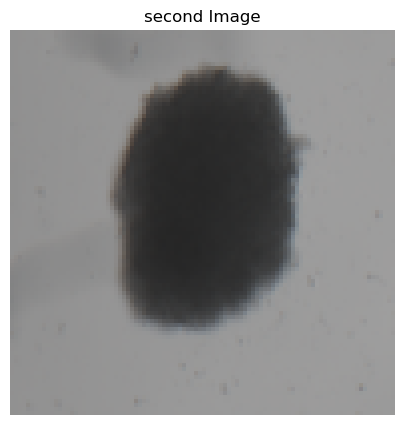

In [23]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [24]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [25]:
print(f"simclr_model: {simclr_model}")

simclr_model: SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [26]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [27]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.821189820766449


In [20]:
# COSINE old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8204046487808228


In [28]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


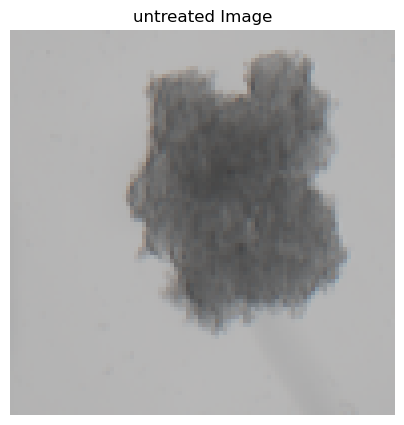

In [29]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [30]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [31]:
# COSINE NEW DATA CROP
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.298863023519516


In [24]:
# cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.19446787238121033


Inference after projection head

In [32]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [33]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [35]:
# Cosine newdata crop 
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.55315762758255


In [ ]:
# Cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

#Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [36]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

torch.Size([1, 20])


In [37]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.26108598709106445


In [29]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.18768171966075897


as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [48]:
print(first_image)
first_image.view(-1).shape


tensor([[[0.5470, 0.5567, 0.5606,  ..., 0.5938, 0.5943, 0.5934],
         [0.5529, 0.5582, 0.5605,  ..., 0.5936, 0.5938, 0.5925],
         [0.5568, 0.5596, 0.5608,  ..., 0.5942, 0.5940, 0.5944],
         ...,
         [0.5541, 0.5543, 0.5565,  ..., 0.5892, 0.5886, 0.5892],
         [0.5542, 0.5552, 0.5562,  ..., 0.5879, 0.5885, 0.5889],
         [0.5540, 0.5557, 0.5556,  ..., 0.5879, 0.5893, 0.5899]],

        [[0.5493, 0.5567, 0.5601,  ..., 0.5925, 0.5925, 0.5928],
         [0.5534, 0.5577, 0.5596,  ..., 0.5928, 0.5925, 0.5917],
         [0.5566, 0.5582, 0.5598,  ..., 0.5935, 0.5934, 0.5935],
         ...,
         [0.5527, 0.5535, 0.5554,  ..., 0.5882, 0.5880, 0.5887],
         [0.5528, 0.5538, 0.5552,  ..., 0.5873, 0.5875, 0.5885],
         [0.5527, 0.5552, 0.5550,  ..., 0.5877, 0.5885, 0.5891]],

        [[0.5513, 0.5575, 0.5597,  ..., 0.5920, 0.5915, 0.5917],
         [0.5549, 0.5581, 0.5595,  ..., 0.5924, 0.5924, 0.5921],
         [0.5574, 0.5582, 0.5601,  ..., 0.5923, 0.5935, 0.

torch.Size([27648])

In [49]:
print(second_image)
second_image.view(-1).shape

tensor([[[0.5667, 0.5681, 0.5692,  ..., 0.6117, 0.6131, 0.6123],
         [0.5668, 0.5676, 0.5689,  ..., 0.6129, 0.6132, 0.6120],
         [0.5672, 0.5673, 0.5695,  ..., 0.6136, 0.6136, 0.6136],
         ...,
         [0.5707, 0.5719, 0.5733,  ..., 0.6065, 0.6071, 0.6066],
         [0.5709, 0.5718, 0.5733,  ..., 0.6054, 0.6066, 0.6055],
         [0.5712, 0.5710, 0.5731,  ..., 0.6048, 0.6062, 0.6054]],

        [[0.5658, 0.5665, 0.5675,  ..., 0.6108, 0.6114, 0.6110],
         [0.5656, 0.5661, 0.5677,  ..., 0.6119, 0.6123, 0.6115],
         [0.5656, 0.5665, 0.5685,  ..., 0.6126, 0.6120, 0.6122],
         ...,
         [0.5698, 0.5702, 0.5724,  ..., 0.6060, 0.6059, 0.6056],
         [0.5689, 0.5699, 0.5719,  ..., 0.6044, 0.6053, 0.6034],
         [0.5692, 0.5697, 0.5727,  ..., 0.6040, 0.6049, 0.6042]],

        [[0.5648, 0.5659, 0.5666,  ..., 0.6107, 0.6111, 0.6106],
         [0.5654, 0.5659, 0.5673,  ..., 0.6115, 0.6118, 0.6110],
         [0.5651, 0.5663, 0.5677,  ..., 0.6125, 0.6118, 0.

torch.Size([27648])

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [55]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

False

In [42]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

tensor([0.9914])

In [44]:
untreated_flat = untreated_image.view(-1)

In [46]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

tensor([0.9834])

In [50]:
first_flat == untreated_flat

tensor([False, False, False,  ..., False, False, False])

orig without resizing

In [60]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9906225204467773


In [61]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9821854829788208


In [62]:
WAS IST DAS?
Mach kein Sinn!

SyntaxError: invalid syntax (2322824841.py, line 2)

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [72]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 3.129988785460241e-12


In [77]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 1.0155029384685969e-13


In [69]:
img1

array([[[34168, 35304, 34600, ..., 39241, 39289, 39033],
        [34168, 35224, 34568, ..., 39225, 38569, 38761],
        [34280, 34984, 35048, ..., 38249, 38249, 39817],
        ...,
        [36792, 35864, 36200, ..., 38009, 36376, 38729],
        [36889, 36504, 36504, ..., 40025, 38297, 38041],
        [36280, 37209, 35656, ..., 37753, 37849, 39897]],

       [[36328, 35848, 34584, ..., 39785, 39609, 38585],
        [35032, 34168, 35944, ..., 39609, 39673, 38201],
        [36392, 35608, 35112, ..., 36953, 39433, 38585],
        ...,
        [35736, 35528, 35240, ..., 39017, 37369, 39017],
        [35144, 35464, 36937, ..., 38697, 38921, 38569],
        [35976, 35752, 35928, ..., 39513, 38921, 37897]],

       [[36680, 35688, 36104, ..., 39977, 39001, 38137],
        [35208, 35848, 35480, ..., 39401, 38681, 37321],
        [35240, 35272, 34856, ..., 37705, 39673, 38265],
        ...,
        [35992, 35560, 34696, ..., 37513, 38393, 38745],
        [35496, 34392, 35272, ..., 37929, 388

In [76]:
img2

array([[[37577, 37369, 36792, ..., 39769, 41050, 39209],
        [37689, 36440, 36873, ..., 39929, 40105, 39881],
        [36728, 37337, 36488, ..., 39097, 40521, 40249],
        ...,
        [37561, 37577, 37449, ..., 38793, 38137, 40297],
        [35784, 38121, 37833, ..., 40025, 39689, 39481],
        [38345, 37065, 38569, ..., 39561, 39497, 39753]],

       [[37321, 37529, 36840, ..., 39881, 39961, 41162],
        [36440, 37049, 37049, ..., 40089, 39321, 40889],
        [36056, 36136, 36376, ..., 38713, 40009, 39321],
        ...,
        [36873, 37625, 38121, ..., 39065, 38425, 39737],
        [36889, 37625, 36328, ..., 39929, 39801, 39033],
        [38233, 37385, 38905, ..., 38953, 38809, 39593]],

       [[36969, 36536, 36536, ..., 41098, 41050, 39577],
        [36680, 36296, 36728, ..., 40073, 40970, 39929],
        [36824, 37353, 37241, ..., 39881, 40249, 40697],
        ...,
        [37449, 37097, 37145, ..., 39177, 38409, 40233],
        [37465, 37993, 37865, ..., 39273, 401

In [75]:
img3

array([[[46155, 46875, 44570, ..., 46283, 45947, 44842],
        [46987, 46747, 45995, ..., 47003, 47467, 46251],
        [45403, 46635, 45915, ..., 45387, 46059, 46059],
        ...,
        [45675, 46555, 44666, ..., 45563, 44538, 47003],
        [46091, 45563, 45851, ..., 47083, 46811, 45435],
        [45131, 45787, 46475, ..., 45995, 45835, 46795]],

       [[46891, 45819, 45979, ..., 46299, 46683, 46507],
        [45371, 45675, 46315, ..., 46427, 45403, 45307],
        [45531, 45307, 45723, ..., 44266, 44858, 45979],
        ...,
        [45707, 45627, 45819, ..., 44538, 44922, 46667],
        [46539, 45611, 45147, ..., 46315, 45755, 45034],
        [45179, 45659, 45851, ..., 46779, 46411, 46011]],

       [[45531, 46171, 45883, ..., 45915, 45579, 46795],
        [46363, 47003, 46331, ..., 46507, 44922, 46507],
        [45531, 45515, 46203, ..., 44554, 45467, 45707],
        ...,
        [45707, 44858, 45451, ..., 45131, 45259, 45691],
        [45787, 47019, 44842, ..., 45819, 453

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.